In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

%matplotlib inline


import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns

import sqlite3

import pickle, joblib

In [6]:
# Import the csv 
df = pd.read_csv("/Users/elizabethlyon/Documents/MGSC410/data/Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,retweet_count,text,tweet_created,tweet_location
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,0,@VirginAmerica What @dhepburn said.,2/24/15 11:35,NaN
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,2/24/15 11:15,NaN
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2/24/15 11:15,Lets Play
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,0,@VirginAmerica it's really aggressive to blast...,2/24/15 11:15,NaN
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,0,@VirginAmerica and it's a really big bad thing...,2/24/15 11:14,NaN


In [7]:
df.shape

(14640, 12)

In [10]:
# find frequency of airlines 
tab = pd.crosstab(index=df['airline'], columns='count')
tab/tab.sum()

col_0,count
airline,
American,0.188456
Delta,0.151776
Southwest,0.165301
US Airways,0.198975
United,0.261066
Virgin America,0.034426


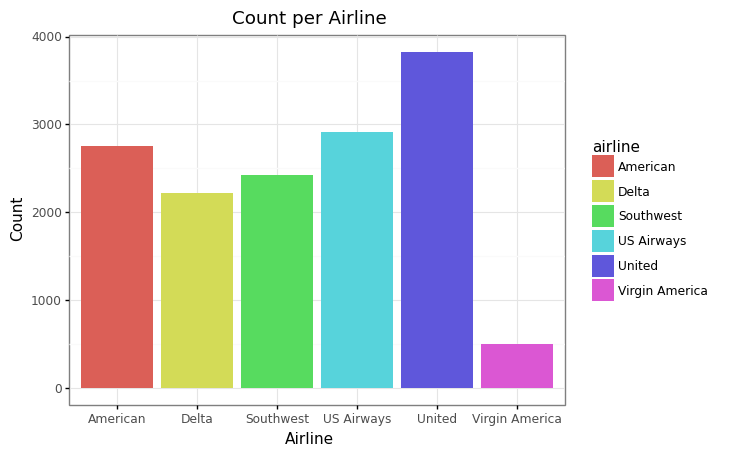

<ggplot: (8790343082469)>

In [20]:
# data exploration 
ggplot(df, aes(x='airline', fill='airline')) + geom_bar() + theme_bw()+ xlab("Airline") + ylab("Count") + ggtitle("Count per Airline")

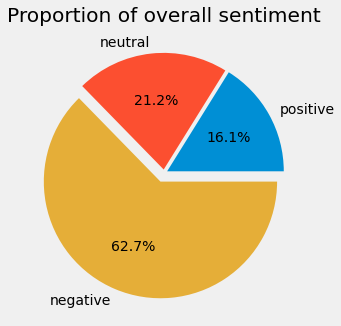

In [11]:
# gets the overall sentiment 
x = df.airline_sentiment.value_counts().sort_values()

plt.figure(figsize=(5, 5))
ax = plt.pie(x = x, labels=x.index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Proportion of overall sentiment')

plt.show()

In [12]:
a = df.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack()
# a['total'] =  [a.values[x].sum() for x in range(0,6)]
a

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


In [13]:
# make new df to see what is the neg sent. breakdown 
df_neg = df[df.airline_sentiment == 'negative']
display(df_neg.shape, df_neg.head())

(9178, 12)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,retweet_count,text,tweet_created,tweet_location
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,0,@VirginAmerica it's really aggressive to blast...,2/24/15 11:15,NaN
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,0,@VirginAmerica and it's a really big bad thing...,2/24/15 11:14,NaN
5,5.703010e+17,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2/24/15 11:14,NaN
15,5.702820e+17,negative,0.6842,Late Flight,0.3684,Virgin America,NaN,smartwatermelon,0,@VirginAmerica SFO-PDX schedule is still MIA.,2/24/15 10:01,"palo alto, ca"
17,5.702770e+17,negative,1.0000,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,0,@VirginAmerica I flew from NYC to SFO last we...,2/24/15 9:39,this place called NYC


In [14]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways',
         'virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway',
         'flight', 'airline', 'airlines']

# I thought the words related the name of airlines are not relevant to the sentiment analysis
# Therefore I decided to append the above names into the list of stop words.
def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elizabethlyon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/elizabethlyon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
df['final_text']= df.text.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

0                                     [dhepburn, said]
1    [plus, youve, added, commercials, experience, ...
2    [didnt, today, must, mean, need, take, another...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: final_text, dtype: object

In [17]:
print(" ".join(df.final_text[0]),'\n')
print(" ".join(df.final_text[1]),'\n')
print(" ".join(df.final_text[100]),'\n')
print(" ".join(df.final_text[1000]),'\n')
print(" ".join(df.final_text[10000]))

dhepburn said 

plus youve added commercials experience tacky 

trying add boy prince ressie sf thursday lax httptcogsbjcgm 

put bag plane seattle waiting line talk someone bag status matter 

waiting day atl since cancelled flightled standby told seats group shows late gets phl


In [18]:
# preprocessing before drawing wordcloud separating the sentiment.

positive = df[df.airline_sentiment == 'positive'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
positive = [" ".join(positive.values[i]) for i in range(len(positive))]
positive = [" ".join(positive)][0]

negative = df[df.airline_sentiment == 'negative'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
negative = [" ".join(negative.values[i]) for i in range(len(negative))]
negative = [" ".join(negative)][0]

neutral = df[df.airline_sentiment == 'neutral'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

print(len(positive), len(negative), len(neutral))

115931 591416 151075


In [90]:
print(positive)

plus youve added commercials experience tacky yes nearly every time fly vx ear worm wont go away well didntbut amazing arrived hour early youre good lt pretty graphics much better minimal iconography great deal already thinking nd trip australia amp havent even gone st trip yet virginmedia im flying fabulous seductive skies take stress away travel httptcoahlxhhkiyn thanks excited first cross country lax mco ive heard nothing great things virgin america daystogo flying know would amazingly awesome bosfll please want fly love graphic httptcoutgrrwaaa love hipster innovation feel good brand great news america could start flights hawaii end year httptcorpzyfe via pacificbiznews moodlighting way fly best experience ever cool calming moodlitmonday freddieawards done done best around hands view downtown los angeles hollywood sign beyond rain mountains httptcodwnfibtr im elevategold good reason rock wow blew mind ladygaga carrieunderwood julie andrews way though ladygaga impressive carrieunder

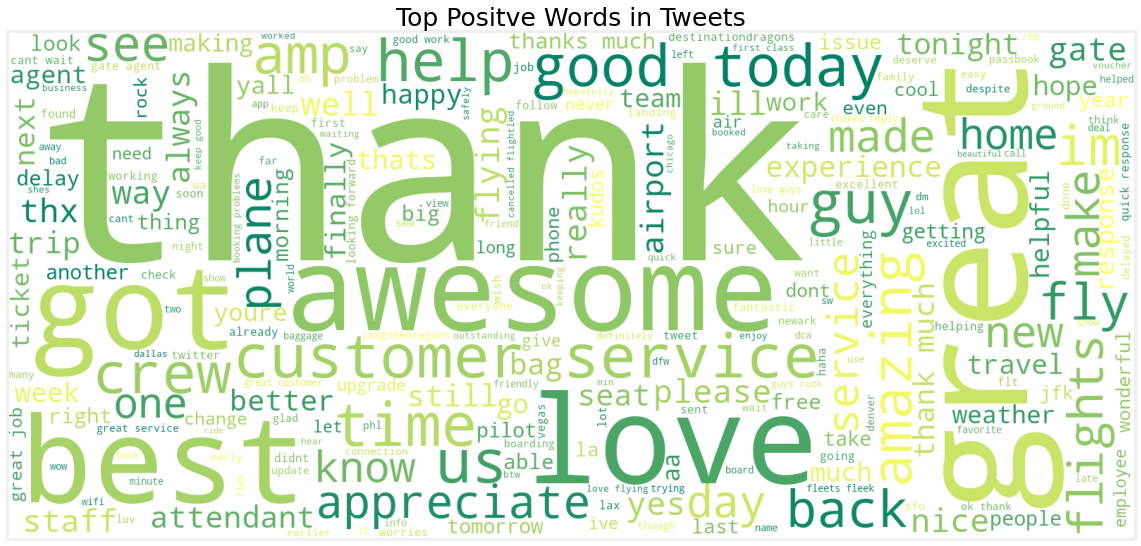

In [27]:
plt.figure(figsize=(18,15))
wc_positive = WordCloud(min_font_size=5,max_words=250,width=1600,height=720,
                       colormap = 'summer', background_color='white').generate(positive)

#plt.imshow(wc_positive,interpolation='bilinear')
plt.imshow(wc_positive)
plt.xticks([])
plt.yticks([])
plt.title('Top Positve Words in Tweets',fontsize=25)
plt.grid(False)

TypeError: Unknown argument type <class 'str'>, expected mapping/aes.

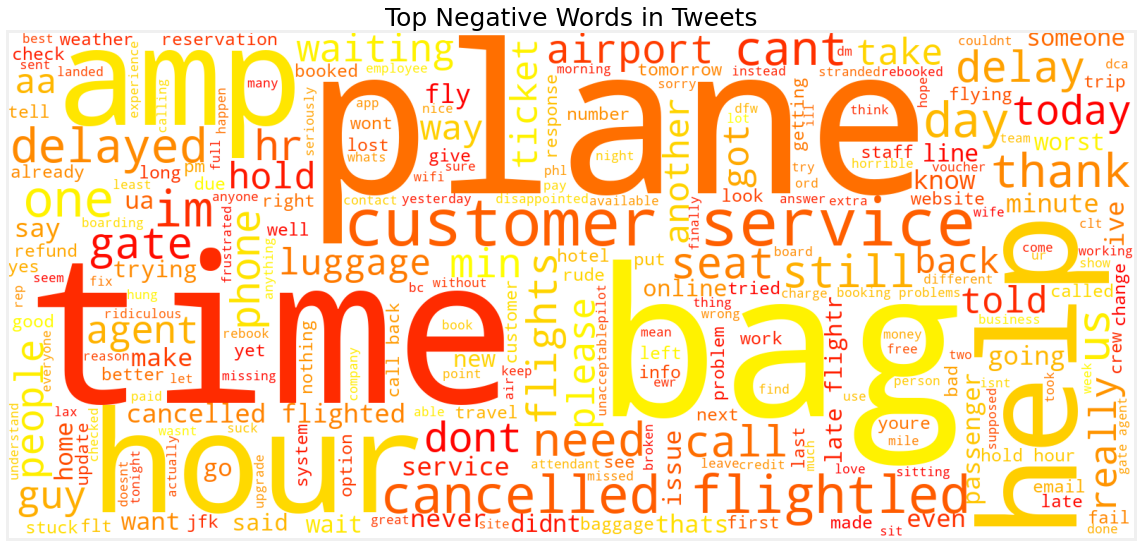

In [28]:
plt.figure(figsize=(18,15))
wc_positive = WordCloud(min_font_size=5,max_words=250,width=1600,height=720,
                       colormap = 'autumn', background_color='white').generate(negative)

plt.imshow(wc_positive)
plt.xticks([])
plt.yticks([])
plt.title('Top Negative Words in Tweets',fontsize=25)
plt.grid(False)

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

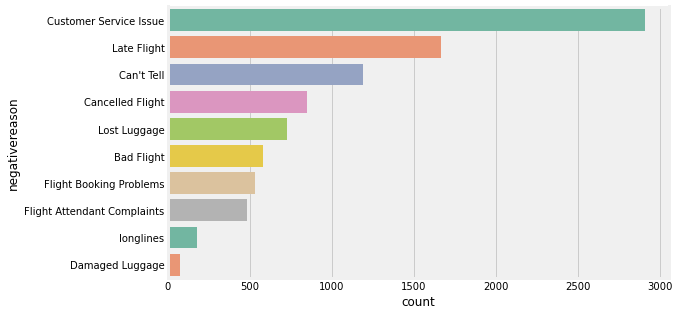

In [29]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data = df_neg, y = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index)

ax.bar_label(ax.containers[0])
ax.set_title('Count per NegativeReason')

plt.show()

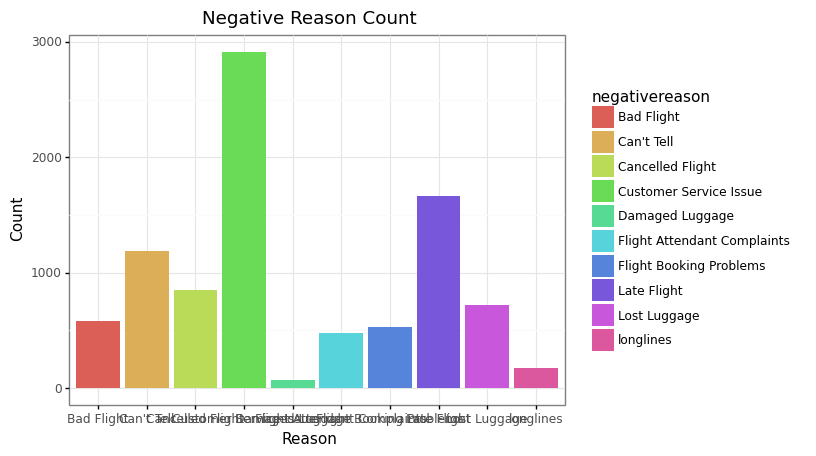

<ggplot: (8790064050685)>

In [30]:
ggplot(df_neg, aes(x='negativereason', fill='negativereason')) + geom_bar() + theme_bw() + xlab("Reason") + ylab("Count") + ggtitle("Negative Reason Count")


AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

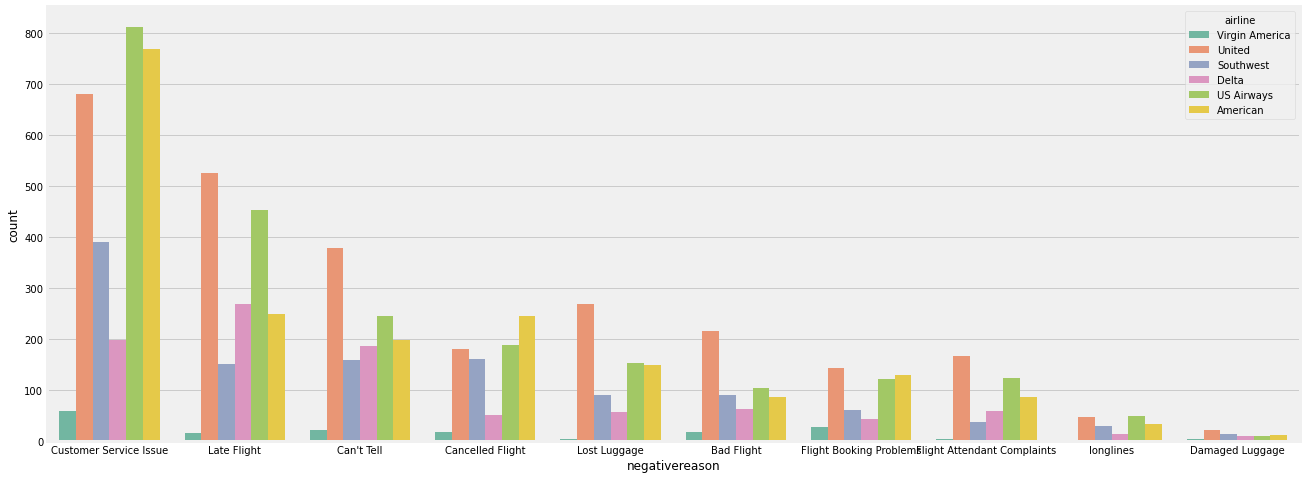

In [31]:
plt.figure(figsize=(20,8))
ax = sns.countplot(data = df_neg, x = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index, hue = 'airline')

ax.bar_label(ax.containers[0])
ax.set_title('Count per NegativeReason')
plt.xticks(rotation=45)
plt.show()

In [25]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
import collections
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [32]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'retweet_count', 'text',
       'tweet_created', 'tweet_location', 'final_text'],
      dtype='object')

In [33]:
all_headlines = ' '.join(df['text'].str.lower())

In [34]:
stopwords = STOPWORDS
stopwords.add('will')

#wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(all_headlines)

wordcloud = WordCloud(min_font_size=5,max_words=250,width=1600,height=720,
                       colormap = 'winter', background_color='white').generate(all_headlines)

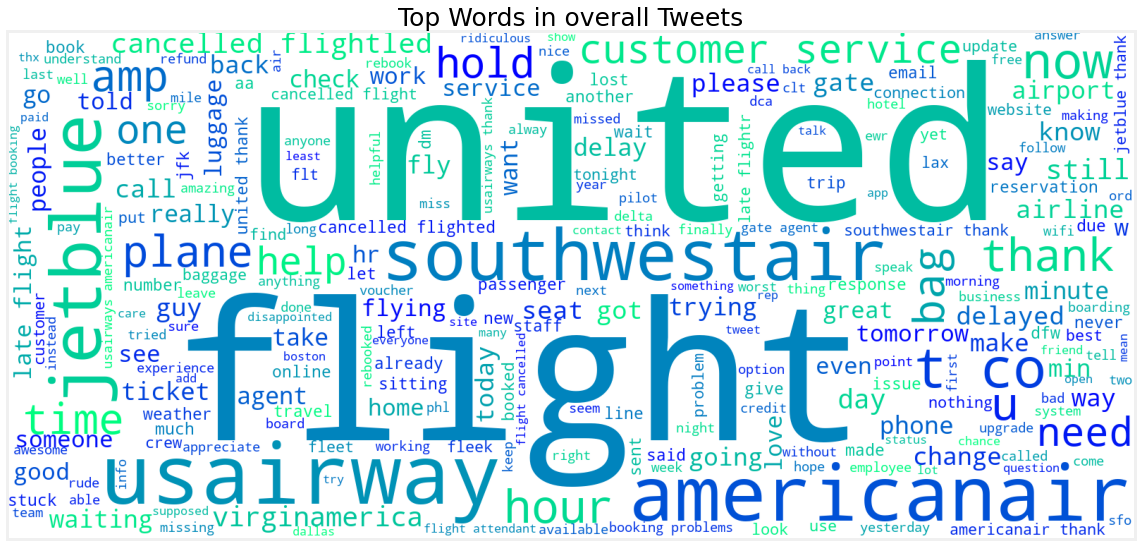

In [35]:
#rcParams['figure.figsize'] = 18, 25
plt.figure(figsize=(18,15))


plt.imshow(wordcloud)
plt.xticks([])
plt.yticks([])
plt.title('Top Words in overall Tweets',fontsize=25)
plt.show()

In [36]:
filtered_words = [word for word in all_headlines.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)

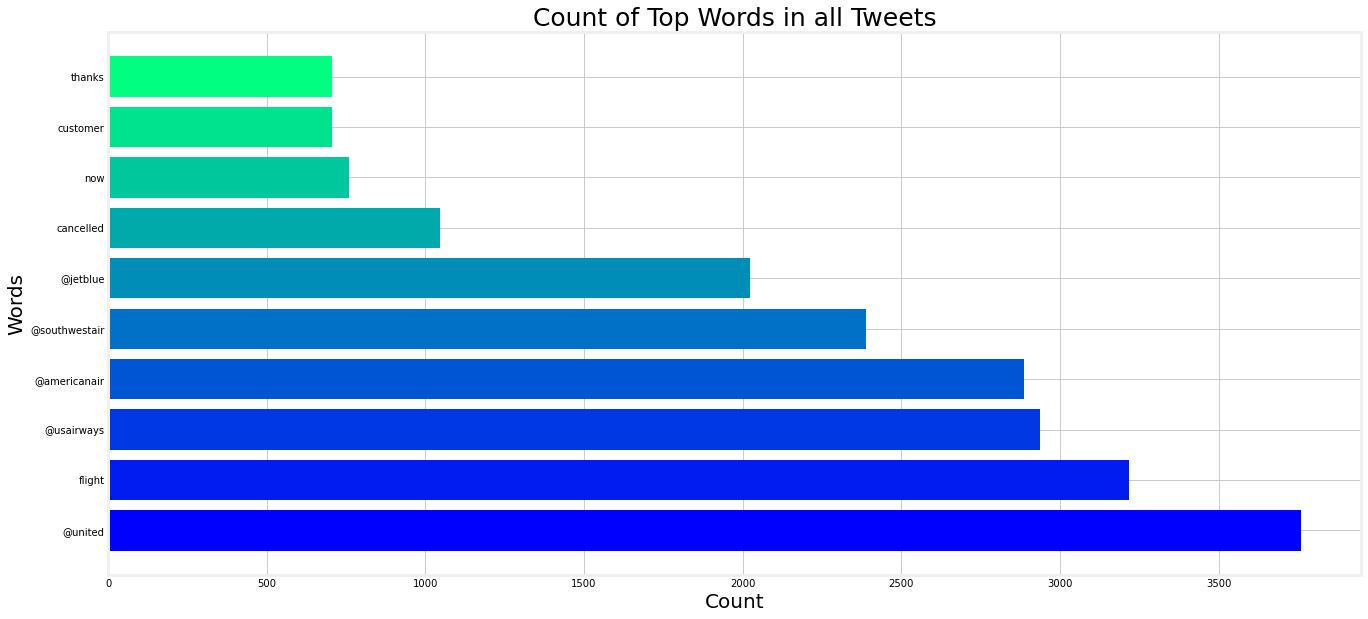

In [39]:
colors = cm.winter(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Count of Top Words in all Tweets',fontsize=25)
plt.xlabel('Count', fontsize=20)
plt.ylabel('Words', fontsize=20)
plt.barh(words, counts, color=colors)

ax = plt.axes()
ax.set_facecolor("white")